<h1 style="color:Red">Goal 1 - Classification of bird songs based on the spectrograms provided</h1>

**Author: Onkar Rajendra Jadhav**

**Date: April 23th, 2023**

<h3 style="color:Purple">Importing Libraries</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch import stack, LongTensor
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import os
import cv2
from sklearn import metrics # confusion matrix

In [3]:
# pip install opencv-python-headless

**Author: Onkar Rajendra Jadhav**

**Date: April 23th, 2023**

<h3 style="color:purple">Step 1: Loading the spectrograms and preprocessing them (re-sizing and normalizing)</h3>

In [3]:
from sklearn.preprocessing import LabelEncoder

# setting random seed
torch.manual_seed(99)
np.random.seed(99)

# Define the folder paths and corresponding labels
spectLocation = ["C:/Users/Teja/Desktop/DSA8023/greypartridge/greypartridgespec", "C:/Users/Teja/Desktop/DSA8023/stockdove/stockdovespec", "C:/Users/Teja/Desktop/DSA8023/turtledove/turtledovespec", "C:/Users/Teja/Desktop/DSA8023/yellowhammer/yellowhammerspec"]
birdLables = np.array(['greypartridge']*1000 + ['stockdove']*1000 + ['turtledove']*1000 + ['yellowhammer']*1000)

labelEncoder = LabelEncoder()
imageLables = labelEncoder.fit_transform(birdLables)

spectData = []
for fpath in spectLocation:
    for fname in os.listdir(fpath):
        if fname.endswith(".png"): # check files ending with '.png'
            file_path_temp = os.path.join(fpath, fname)
            img = cv2.imread(file_path_temp, 0)
            imageResized = cv2.resize(img, (128, 128))  # resize each spectrogram to the same shape
            spectData.append(imageResized)
spectData = np.array(spectData)

# Normalize the spectrograms
spectDataNorm = spectData / 255.0 # to get pixel values in range of 0-1

**Author: Onkar Rajendra Jadhav**

**Date: April 23th, 2023**

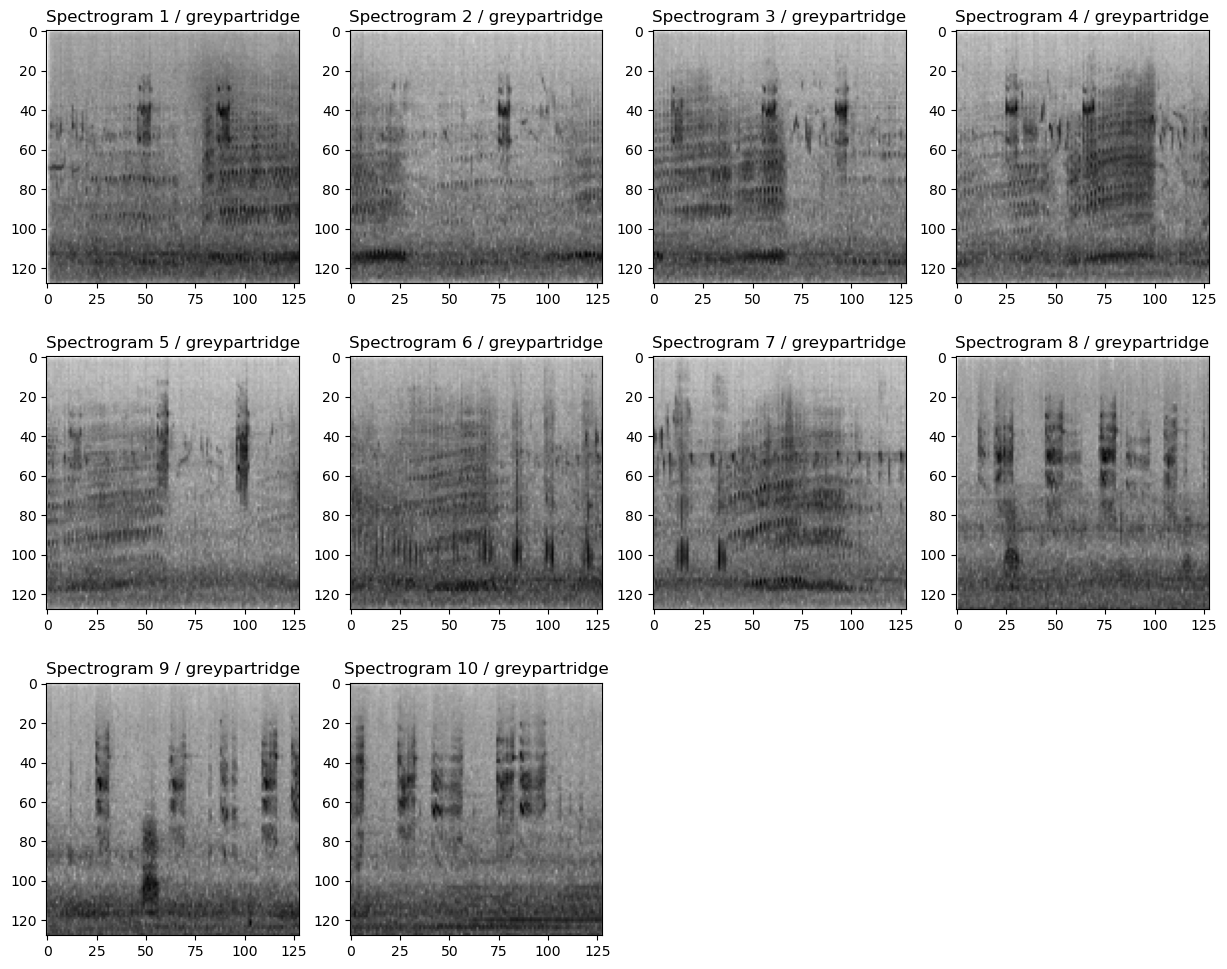

In [4]:
# displaying spectrograms
countSpect = min(len(spectDataNorm), 10) # displaying first 10 spectrograms
countCols = 4
countRows = int(np.ceil(countSpect / countCols))

fig, axs = plt.subplots(countRows, countCols, figsize = (15,12))

for i, ax in enumerate(axs.flat):
        if i < countSpect:
            ax.imshow(spectDataNorm[i], cmap = "gray")
            ax.set_title(f"Spectrogram {i+1} / {birdLables[i]}") # spectogram number / bird species
        else:
            ax.axis("off")
            
# plt.tight_layout()
plt.show()

**Author: Onkar Rajendra Jadhav**

**Date: April 23th, 2023**

<h3 style="color:purple">Step 2: Spliting the data into training and test/validation sets</h3>

In [5]:
# setting seed
torch.manual_seed(99)
np.random.seed(99)

# Split the data into training and validation sets

trainSpect, testSpect, trainLabels, testLabels = train_test_split(spectDataNorm, imageLables, test_size=0.2, random_state=42)
    
trainSpect = torch.from_numpy(trainSpect).float()
trainLabels = torch.from_numpy(trainLabels).long()

testSpect = torch.from_numpy(testSpect).float()
testLabels = torch.from_numpy(testLabels).long()

trainSpect = trainSpect.unsqueeze(1)
testSpect = testSpect.unsqueeze(1)

trainDataset = TensorDataset(trainSpect, trainLabels)
testDataset = TensorDataset(testSpect, testLabels)

trainLoader = DataLoader(trainDataset, batch_size = 128, shuffle = True)
testLoader = DataLoader(testDataset, batch_size = 128, shuffle = False)

# Print the shape of the training and validation sets
print("Training set shape:", trainSpect.shape, trainLabels.shape)
print("Test or Validation set shape:", testSpect.shape, testLabels.shape)

Training set shape: torch.Size([3200, 1, 128, 128]) torch.Size([3200])
Test or Validation set shape: torch.Size([800, 1, 128, 128]) torch.Size([800])


**Author: Onkar Rajendra Jadhav**

**Date: April 23th, 2023**

<h3 style="color:purple">Step 3: Build a Model (Convolutional Neural Network)</h3>

In [6]:
# building a CNN model

classesCount = len(np.unique(imageLables)) # 4

class CNN_Image(nn.Module):
    def __init__(self, inChannels):
        super(CNN_Image, self).__init__()
        
        self.cnn_image = nn.Sequential(
            nn.Conv2d(inChannels, 16, 3, stride = 1, padding =1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(16, 32, 3, stride = 1, padding =1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 32, 3, stride = 1, padding =1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
        )
        self.fc = nn.Sequential(
            nn.Linear(8192, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(inplace = True),
            nn.Linear(200, classesCount)
        )
        
    def forward(self, x):
        out = self.cnn_image(x)
        out = self.fc(out)
        
        return out

**Author: Sai Chaitanya Mondi**

**Date: April 23th, 2023**

<h3 style="color:purple">Step 4: Define a train function</h3>

In [7]:
num_epochs = 5
classesCount = len(np.unique(imageLables)) # 4

def train(model, trainLoader, testLoader, num_epochs, optimizer):
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    epochs, epoch_loss, trainAcc, testAcc = [], [], [], []
    
    for n in range(num_epochs):
        trainLoss = 0
        
        for i, data in enumerate(trainLoader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            trainLoss += loss.item()
        
        epoch_loss.append(trainLoss / len(trainLoader))
        trainAcc.append(getAccuracy(model, trainLoader))
        testAcc.append(getAccuracy(model, testLoader))
        epochs.append(n)
        
        print(f"Epoch {n+1}: Training Loss: {epoch_loss[-1]:>0.3f}")
        print(f"Training Accuracy: {100 * trainAcc[-1]: >0.2f}%")
        print(f"Testing Accuracy: {100 * testAcc[-1]: >0.2f}%")
        print("-------------------------------")
        
    # plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    ax1.set_title("Training Curve")
    ax1.plot(epoch_loss, label="Train")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    
    ax2.set_title("Comparison between Train and Test Accuracy Curves")
    ax2.plot(epochs, trainAcc, label="Train")
    ax2.plot(epochs, testAcc, label="Test")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="best")
        
        
def getAccuracy(model, dataLoader):
    correct, total = 0, 0
    model.eval()
    
    with torch.no_grad():
        for data in dataLoader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

**Author: Sai Chaitanya Mondi**

**Date: April 23th, 2023**

<h3 style="color:purple">Step 5: Run and check for results</h3>

Epoch 1: Training Loss: 1.094
Training Accuracy: 24.72%
Testing Accuracy: 26.12%
-------------------------------
Epoch 2: Training Loss: 1.356
Training Accuracy: 46.44%
Testing Accuracy: 45.62%
-------------------------------
Epoch 3: Training Loss: 1.125
Training Accuracy: 56.84%
Testing Accuracy: 54.87%
-------------------------------
Epoch 4: Training Loss: 0.993
Training Accuracy: 65.69%
Testing Accuracy: 66.12%
-------------------------------
Epoch 5: Training Loss: 0.817
Training Accuracy: 72.56%
Testing Accuracy: 72.38%
-------------------------------
Epoch 6: Training Loss: 0.686
Training Accuracy: 75.47%
Testing Accuracy: 74.75%
-------------------------------
Epoch 7: Training Loss: 0.607
Training Accuracy: 78.94%
Testing Accuracy: 77.00%
-------------------------------
Epoch 8: Training Loss: 0.563
Training Accuracy: 80.06%
Testing Accuracy: 80.38%
-------------------------------
Epoch 9: Training Loss: 0.505
Training Accuracy: 83.88%
Testing Accuracy: 82.88%
---------------

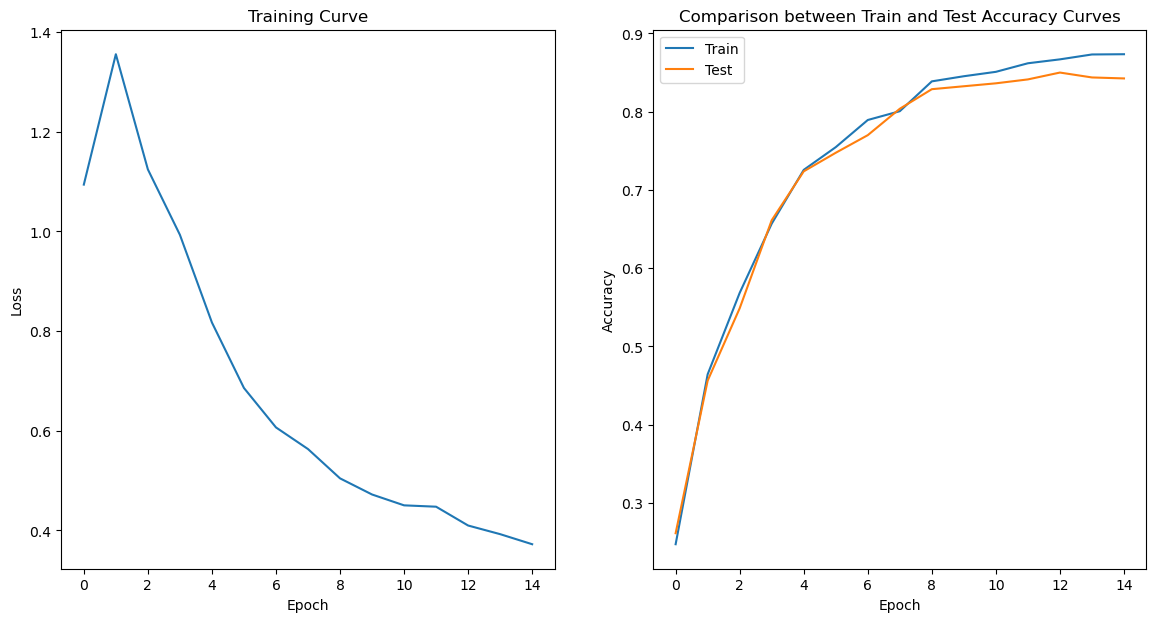

In [8]:
model = CNN_Image(inChannels=1)
optimizer = optim.Adam(model.parameters(), lr = 2e-4, weight_decay = 3e-3)
train(model, trainLoader, testLoader, 15, optimizer)
print("Done!")

Model Interpretation: Our model is performing well with good accuracy. From the second plot above, as the training curve <span style="color:blue">(Blue)</span> is slightly higher than the validation curve <span style="color:orange">(Orange)</span>, we can interpret that the model is slightly overfitting. This can be improved by increasing the size of training data, increasing dropouts and weight decay term.

**Author: Sai Chaitanya Mondi**

**Date: April 23th, 2023**

<h3 style="color:purple">Step 6: Confusion Matrix</h3>

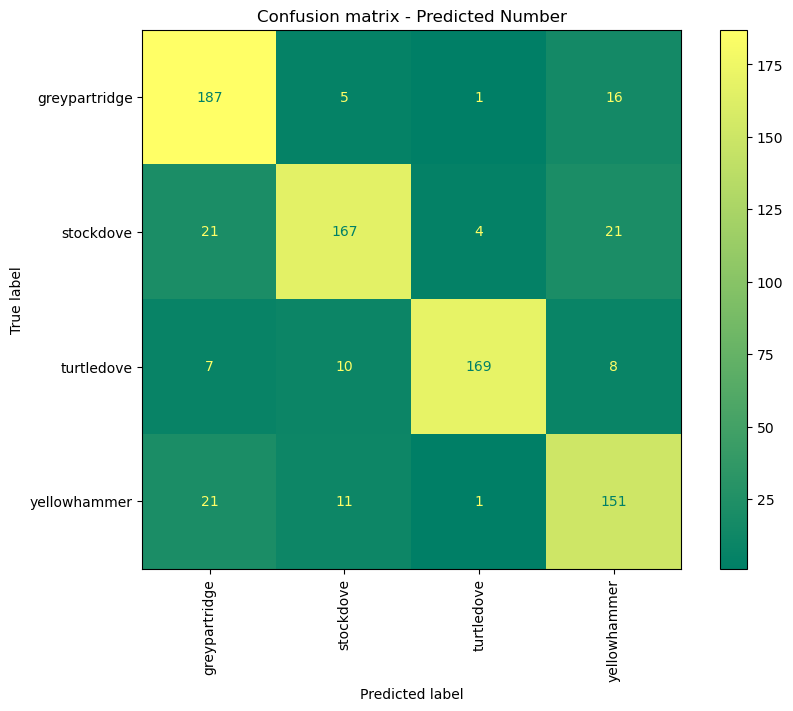

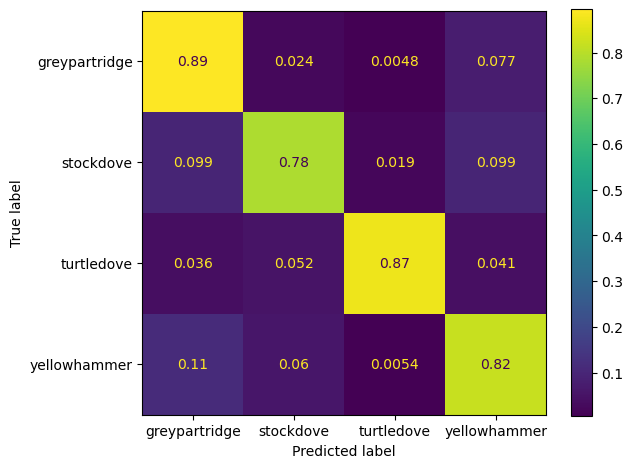

In [12]:
yTrue = []
yPred = []

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        yTrue += labels.numpy().tolist()
        yPred += predicted.numpy().tolist()
        

# plotting
fig, ax = plt.subplots(ncols=1, figsize=(10, 7))

# first plot
disp = metrics.ConfusionMatrixDisplay.from_predictions(yTrue, yPred, display_labels=np.unique(birdLables), normalize='true')
#disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='.2f')
ax.set_title('Confusion matrix - Proportion')

# second plot
confMat = metrics.confusion_matrix(yTrue, yPred)
dispMat = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=np.unique(birdLables))
dispMat.plot(ax=ax, cmap='summer')
ax.set_title('Confusion matrix - Predicted Number')
ax.set_xticklabels(np.unique(birdLables), rotation='vertical')

plt.tight_layout()



**Author: Sai Chaitanya Mondi**

**Date: April 23th, 2023**

<h3 style="color:purple">Performance Metrics</h3>

In [75]:
# F1 Score
f1Score = metrics.f1_score(yTrue, yPred, average = "weighted")
print(f"F1 Score is {f1Score:0.2f}, means the model is correctly identifying the classes of the given dataset")
print(f"\n")

# Accuracy
modelAcc = metrics.accuracy_score(yTrue, yPred)
print(f"Model's accuracy is {modelAcc * 100:0.2f}%")
print(f"\n")

# Classification Report
classReport = metrics.classification_report(yTrue, yPred)
print(f"The Classification Report is as below:\n {classReport}")

F1 Score is 0.84, means the model is correctly identifying the classes of the given dataset


Model's accuracy is 84.50%


The Classification Report is as below:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       209
           1       0.78      0.84      0.81       213
           2       0.92      0.91      0.92       194
           3       0.88      0.75      0.81       184

    accuracy                           0.84       800
   macro avg       0.85      0.84      0.85       800
weighted avg       0.85      0.84      0.84       800



**Author: Onkar Rajendra Jadhav**

**Date: April 23th, 2023**

<h3 style="color:purple">Running the model for 70 epochs to get more information on the curve</h3>

Epoch 1: Training Loss: 1.100
Training Accuracy: 24.72%
Testing Accuracy: 26.12%
-------------------------------
Epoch 2: Training Loss: 1.279
Training Accuracy: 60.62%
Testing Accuracy: 60.12%
-------------------------------
Epoch 3: Training Loss: 0.902
Training Accuracy: 71.19%
Testing Accuracy: 70.38%
-------------------------------
Epoch 4: Training Loss: 0.693
Training Accuracy: 76.41%
Testing Accuracy: 76.88%
-------------------------------
Epoch 5: Training Loss: 0.612
Training Accuracy: 80.59%
Testing Accuracy: 79.62%
-------------------------------
Epoch 6: Training Loss: 0.567
Training Accuracy: 80.66%
Testing Accuracy: 78.50%
-------------------------------
Epoch 7: Training Loss: 0.522
Training Accuracy: 81.94%
Testing Accuracy: 80.75%
-------------------------------
Epoch 8: Training Loss: 0.500
Training Accuracy: 82.47%
Testing Accuracy: 80.38%
-------------------------------
Epoch 9: Training Loss: 0.468
Training Accuracy: 84.94%
Testing Accuracy: 82.00%
---------------

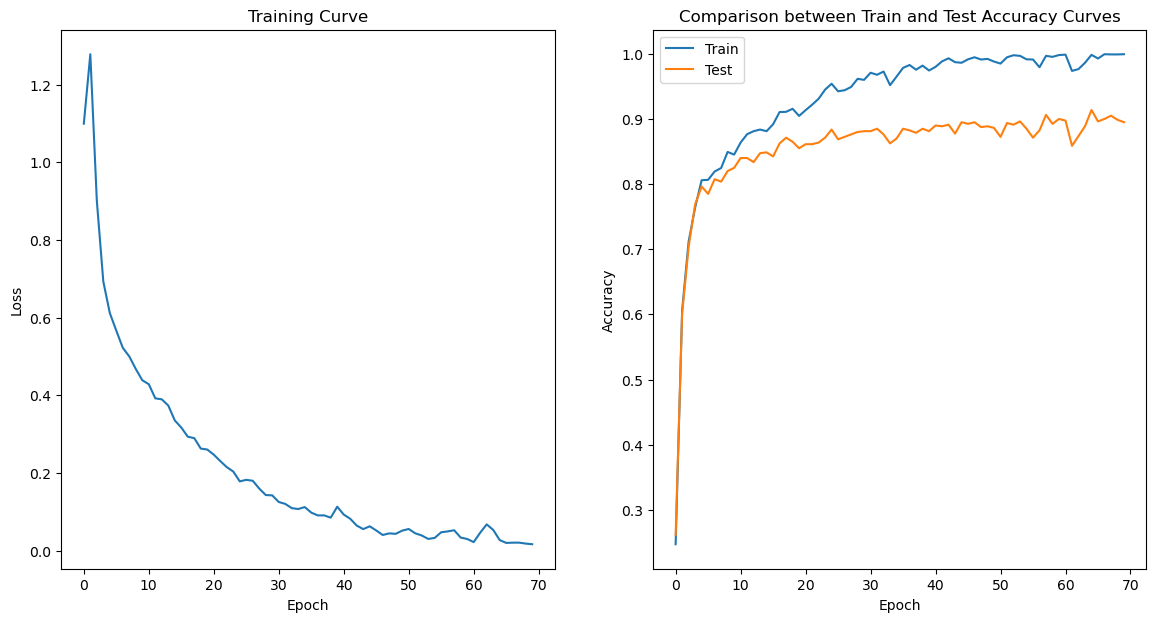

In [14]:
model_temp = CNN_Image(inChannels=1)
optimizer = optim.Adam(model_temp.parameters(), lr = 2e-4, weight_decay = 3e-3)
train(model_temp, trainLoader, testLoader, 70, optimizer)
print("Done!")

**Author: Onkar Rajendra Jadhav**

**Date: April 23th, 2023**

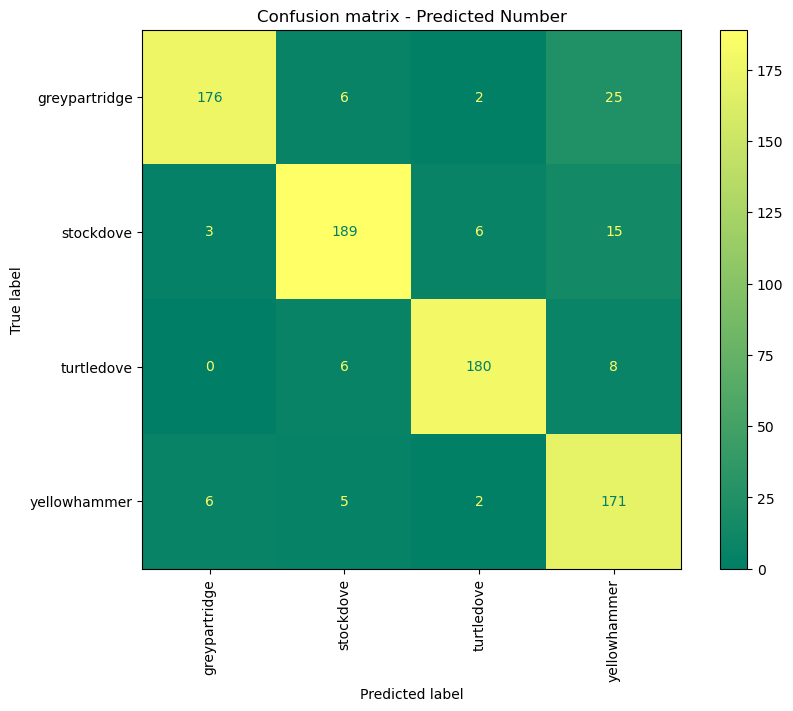

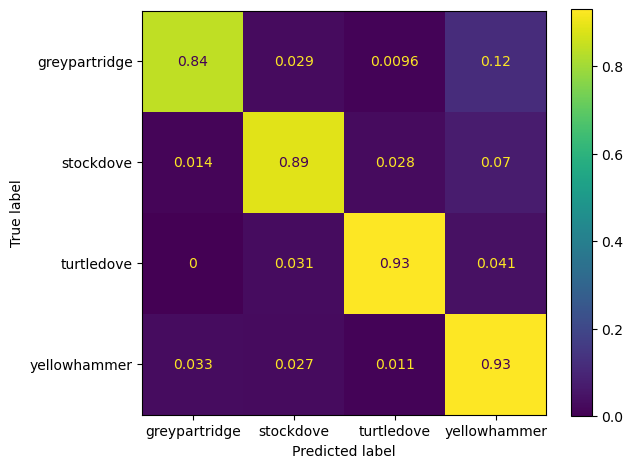

In [16]:
yTrue1 = []
yPred1 = []

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        outputs = model_temp(inputs)
        _, predicted = torch.max(outputs.data, 1)
        yTrue1 += labels.numpy().tolist()
        yPred1 += predicted.numpy().tolist()
        

# plotting
fig, ax = plt.subplots(ncols=1, figsize=(10, 7))

# first plot
disp1 = metrics.ConfusionMatrixDisplay.from_predictions(yTrue1, yPred1, display_labels=np.unique(birdLables), normalize='true')
#disp1.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='.2f')
ax.set_title('Confusion matrix - Proportion')

# second plot
confMat1 = metrics.confusion_matrix(yTrue1, yPred1)
dispMat1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat1, display_labels=np.unique(birdLables))
dispMat1.plot(ax=ax, cmap='summer')
ax.set_title('Confusion matrix - Predicted Number')
ax.set_xticklabels(np.unique(birdLables), rotation='vertical')

plt.tight_layout()
plt.show()


In [17]:
# performance metrics - with more epochs

 

# F1 Score
f1Score1 = metrics.f1_score(yTrue1, yPred1, average = "weighted")
print(f"F1 Score is {f1Score1:0.2f}, means the model is correctly identifying the classes of the given dataset")
print(f"\n")

 

# Accuracy
modelAcc1 = metrics.accuracy_score(yTrue1, yPred1)
print(f"Model's accuracy is {modelAcc1 * 100:0.2f}%")
print(f"\n")

 

# Classification Report
classReport1 = metrics.classification_report(yTrue1, yPred1)
print(f"The Classification Report is as below:\n {classReport1}")

SyntaxError: invalid non-printable character U+00A0 (3380157930.py, line 3)